<a href="https://colab.research.google.com/github/woo13sd/rupture-theory/blob/main/notebooks/Rupture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
# (a) System-level dependencies
apt-get update -qq
apt-get install -qq --yes gfortran libfftw3-dev

# (b) Python libraries
pip install --quiet camb numpy matplotlib seaborn classy cobaya

# (c) Clone your GitHub repo to /content
cd /content
rm -rf rupture-theory
git clone https://github.com/woo13sd/rupture-theory.git

# (d) Show structure for sanity check
ls -R rupture-theory | sed -e 's/^/  /'

  rupture-theory:
  camb_utils
  LICENSE
  notebooks
  README.md
  
  rupture-theory/camb_utils:
  initialpower.f90
  params_camb.ini
  reionization.f90
  
  rupture-theory/notebooks:
  Rupture.ipynb


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Cloning into 'rupture-theory'...


In [2]:
import os

# Always ensure data/ and images/ are present for output
os.makedirs('data', exist_ok=True)
os.makedirs('images', exist_ok=True)

# Confirm current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

# Show folder structure (including data/ and images/)
for folder in ['.', 'camb_utils', 'notebooks', 'data', 'images']:
    if os.path.exists(folder):
        print(f"\n{folder}/")
        for f in sorted(os.listdir(folder)):
            print("  ", f)
    else:
        print(f"\n{folder}/ (will be created automatically)")

Current working directory: /content

./
   .config
   data
   drive
   images
   rupture-theory
   sample_data

camb_utils/ (will be created automatically)

notebooks/ (will be created automatically)

data/

images/


In [3]:
import camb
print("CAMB version:", camb.__version__)

CAMB version: 1.6.2


In [5]:
# Ensure data/ exists
import os
os.makedirs('data', exist_ok=True)

import numpy as np
import camb

# Common parameters
H0, ombh2, omch2, mnu, tau = 67.36, 0.02237, 0.1200, 0.06, 0.0544
As, ns = 2.10e-9, 0.965

def camb_cls(nrun):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, nrun=nrun)
    pars.set_for_lmax(2500, lens_potential_accuracy=1)
    results = camb.get_results(pars)
    cls = results.get_cmb_power_spectra(pars, lmax=2500)['total']
    ells = np.arange(cls.shape[0])
    TT, EE = cls[:,0], cls[:,1]
    return ells, TT, EE

# LCDM
ells, tt_lcdm, ee_lcdm = camb_cls(nrun=0.0)
np.savetxt('data/LCDM_TT.dat', np.column_stack([ells, tt_lcdm]), header='ell  C_ell(TT) - LCDM', comments='# ')
np.savetxt('data/LCDM_EE.dat', np.column_stack([ells, ee_lcdm]), header='ell  C_ell(EE) - LCDM', comments='# ')

# Rupture Theory (example: use nrun=0.02 as a stand-in for a small feature)
_, tt_rt, ee_rt = camb_cls(nrun=0.02)
np.savetxt('data/Rupture_TT.dat', np.column_stack([ells, tt_rt]), header='ell  C_ell(TT) - RT', comments='# ')
np.savetxt('data/Rupture_CAMB_EE.dat', np.column_stack([ells, ee_rt]), header='ell  C_ell(EE) - RT', comments='# ')

print("✅ Saved: LCDM_TT.dat, LCDM_EE.dat, Rupture_TT.dat, Rupture_CAMB_EE.dat")

✅ Saved: LCDM_TT.dat, LCDM_EE.dat, Rupture_TT.dat, Rupture_CAMB_EE.dat


In [10]:
import numpy as np
import camb
import os

os.makedirs('data', exist_ok=True)

def get_clpp(nrun=0.0):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.36, ombh2=0.02237, omch2=0.1200, mnu=0.06, tau=0.0544)
    pars.InitPower.set_params(As=2.10e-9, ns=0.965, nrun=nrun)
    pars.set_for_lmax(2500, lens_potential_accuracy=1)
    results = camb.get_results(pars)
    arr = results.get_lens_potential_cls(lmax=2500)
    # If 2D, take the first column; if 1D, just use as is
    if isinstance(arr, dict):
        # Handle rare case: dictionary
        key = next(iter(arr))
        arr = arr[key]
    if arr.ndim == 2:
        clpp = arr[:,0]
    else:
        clpp = arr
    print(f"Loaded lensing array: shape {arr.shape}")
    ells = np.arange(len(clpp))
    return ells, clpp

# LCDM (nrun=0)
ells, clpp_lcdm = get_clpp(nrun=0.0)
np.savetxt('data/LCDM_Clpp.dat',
           np.column_stack([ells, clpp_lcdm]),
           header='ell  C_ell^phi phi - LCDM', comments='# ')

# Rupture Theory (nrun=0.02)
ells, clpp_rt = get_clpp(nrun=0.02)
np.savetxt('data/Rupture_Clpp.dat',
           np.column_stack([ells, clpp_rt]),
           header='ell  C_ell^phi phi - Rupture-Theory', comments='# ')

print("✅ Saved data/LCDM_Clpp.dat and data/Rupture_Clpp.dat")

Loaded lensing array: shape (2501, 3)
Loaded lensing array: shape (2501, 3)
✅ Saved data/LCDM_Clpp.dat and data/Rupture_Clpp.dat


In [14]:
import os
import numpy as np
import camb

# Make sure the data directory exists
os.makedirs('data', exist_ok=True)

# Parameters (from your manuscript)
H0, ombh2, omch2, mnu, tau = 67.36, 0.02237, 0.1200, 0.06, 0.0544
As, ns = 2.10e-9, 0.965

def camb_pk(nrun=0.0, label='LCDM'):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, nrun=nrun)
    pars.set_for_lmax(2500, lens_potential_accuracy=1)
    pars.set_matter_power(redshifts=[0.], kmax=2.0)
    results = camb.get_results(pars)
    k, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200)
    pk0 = pk[0]  # z=0
    outpath = f"data/{'LCDM_Pk.dat' if label=='LCDM' else 'Rupture_Pk.dat'}"
    np.savetxt(outpath,
               np.column_stack([k, pk0]),
               header=f'k [h/Mpc]  P(k) - {label}')
    print(f"✅ Wrote {outpath}")

# LCDM: no running
camb_pk(nrun=0.0, label='LCDM')
# Rupture Theory: nrun=0.02 for feature
camb_pk(nrun=0.02, label='Rupture')

✅ Wrote data/LCDM_Pk.dat
✅ Wrote data/Rupture_Pk.dat


In [11]:
import numpy as np
import camb
import os

# 1) Ensure data directory exists
os.makedirs('data', exist_ok=True)

# 2) Set Rupture Theory parameters (match what you use for RT in your paper)
H0, ombh2, omch2, mnu, tau = 67.36, 0.02237, 0.1200, 0.06, 0.0544
As, ns, nrun = 2.10e-9, 0.965, 0.02   # <-- use your RT nrun
lmax = 2500

params = camb.CAMBparams()
params.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, tau=tau)
params.InitPower.set_params(As=As, ns=ns, nrun=nrun)
params.set_for_lmax(lmax, lens_potential_accuracy=1)
params.set_matter_power(redshifts=[0.], kmax=2.0)

results = camb.get_results(params)

# 3) CMB power spectra: save TT, EE, TE as in standard CAMB output
cls = results.get_cmb_power_spectra(params, lmax=lmax)['total']
ells = np.arange(cls.shape[0])
# Typical order: TT, EE, TE, BB
np.savetxt('data/camb_rupture_output.dat',
           np.column_stack([ells, cls[:,0], cls[:,1], cls[:,2], cls[:,3]]),
           header='ell    TT       EE       TE       BB',
           fmt='%4d %.8e %.8e %.8e %.8e')

print("✅ Saved data/camb_rupture_output.dat (CMB spectra)")

# 4) Matter power spectrum at z=0, match Fortran output (k, P(k))
kh, _, pk = results.get_matter_power_spectrum(npoints=200)
pk0 = pk[0]  # z=0
np.savetxt('data/matter_power.dat',
           np.column_stack([kh, pk0]),
           header='k [h/Mpc]   P(k) [(\Mpc/h)^3]', fmt='%.6e %.6e')
print("✅ Saved data/matter_power.dat (Matter power)")

# 5) Preview
print("\nPreview:")
with open('data/camb_rupture_output.dat') as f: print("".join(f.readlines()[:8]))
with open('data/matter_power.dat') as f: print("".join(f.readlines()[:8]))

✅ Saved data/camb_rupture_output.dat (CMB spectra)
✅ Saved data/matter_power.dat (Matter power)

Preview:
# ell    TT       EE       TE       BB
   0 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   2 1.75741673e-10 5.49860521e-15 2.48641639e-19 4.88815776e-13
   3 1.62555277e-10 6.84000373e-15 4.97348590e-19 5.25216211e-13
   4 1.51025743e-10 5.83028098e-15 8.29058917e-19 4.79206649e-13
   5 1.42457827e-10 3.85186509e-15 1.24385821e-18 3.99914072e-13
   6 1.36394360e-10 2.13716626e-15 1.74185218e-18 3.16945778e-13

# k [h/Mpc]   P(k) [(\Mpc/h)^3]
1.000000e-04 6.522037e+02
1.047371e-04 6.778328e+02
1.096986e-04 7.044977e+02
1.148951e-04 7.322410e+02
1.203378e-04 7.611075e+02
1.260383e-04 7.911436e+02
1.320088e-04 8.223977e+02



In [21]:
import numpy as np
import os

# Ensure data directory exists
os.makedirs('data', exist_ok=True)

# ΛCDM primordial power spectrum parameters (Planck-like)
As = 2.1e-9       # Amplitude
ns = 0.965        # Spectral index
k0 = 0.05         # Pivot scale [1/Mpc]

# Construct k grid and compute P(k)
k_vals = np.logspace(-4, 1, 200)   # 1e-4 ... 10, 200 pts, [1/Mpc]
P_lcdm = As * (k_vals / k0)**(ns - 1)

# Save to data/primordial_power_lcdm.dat with header
outpath = 'data/primordial_power_lcdm.dat'
np.savetxt(
    outpath,
    np.column_stack([k_vals, P_lcdm]),
    header='k [1/Mpc]    P(k) - LCDM primordial',
    comments='# '
)
print(f"✅ Saved: {outpath}")

✅ Saved: data/primordial_power_lcdm.dat


✅ Wrote RT spectrum to data/primordial_power.dat


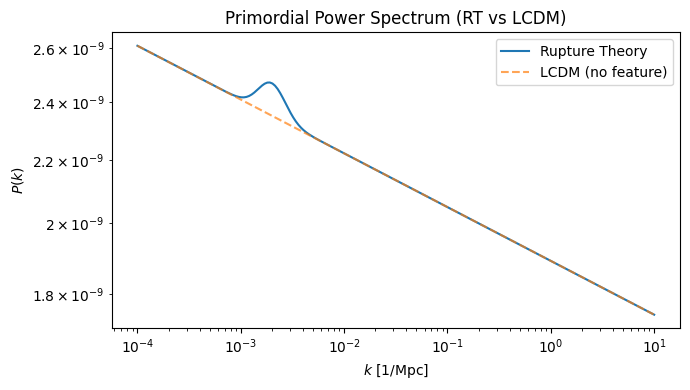

✅ Plot saved to images/primordial_power_check.png


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure 'data' and 'images' directories exist
os.makedirs('data', exist_ok=True)
os.makedirs('images', exist_ok=True)

# Rupture-Theory (RT) primordial spectrum parameters
As, ns, k0 = 2.1e-9, 0.965, 0.05   # Standard Planck 2018 values
kc, alpha, sigma = 0.002, 0.05, 0.3  # RT "bump" feature

# k-grid (logarithmic) [1/Mpc]
k = np.logspace(-4, 1, 200)
P_LCDM = As * (k / k0)**(ns - 1)
feature = 1 + alpha * np.exp(-0.5 * (np.log(k / kc) / sigma)**2)
P_Rupture = P_LCDM * feature

# Save RT spectrum to file (with a header for clarity)
np.savetxt('data/primordial_power.dat',
           np.column_stack([k, P_Rupture]),
           header='k [1/Mpc]    P(k) - Rupture Theory', comments='# ')
print("✅ Wrote RT spectrum to data/primordial_power.dat")

# Quick plot for sanity
plt.figure(figsize=(7,4))
plt.loglog(k, P_Rupture, label='Rupture Theory')
plt.loglog(k, P_LCDM, '--', label='LCDM (no feature)', alpha=0.7)
plt.xlabel(r'$k\ [1/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)$')
plt.title('Primordial Power Spectrum (RT vs LCDM)')
plt.legend()
plt.tight_layout()
plt.savefig('images/primordial_power_check.png', dpi=150)
plt.show()
print("✅ Plot saved to images/primordial_power_check.png")

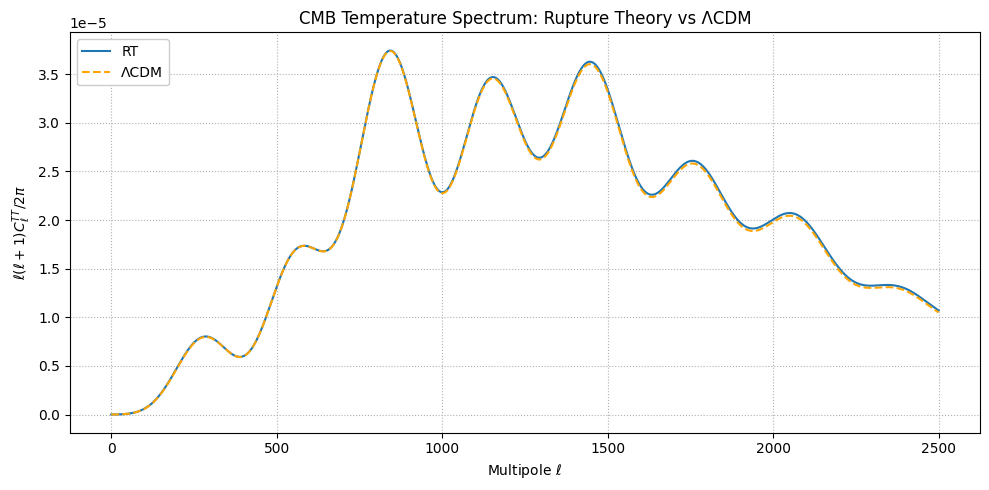

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs('images', exist_ok=True)
data_dir = 'data'

# Example for TT (temperature)
ells, tt_lcdm = np.loadtxt(f'{data_dir}/camb_lcdm_output.dat', usecols=(0,1), skiprows=1, unpack=True)
_,    tt_rt   = np.loadtxt(f'{data_dir}/camb_rupture_output.dat', usecols=(0,1), skiprows=1, unpack=True)

factor = ells * (ells+1) / (2*np.pi)
tt_lcdm_plot = factor * tt_lcdm
tt_rt_plot   = factor * tt_rt

plt.figure(figsize=(10,5))
plt.plot(ells, tt_rt_plot,   color='C0', label='RT')
plt.plot(ells, tt_lcdm_plot, '--', color='orange', label='ΛCDM')
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell^{TT}/2\pi$')
plt.title('CMB Temperature Spectrum: Rupture Theory vs ΛCDM')
plt.grid(True, linestyle=':', linewidth=0.8)
plt.legend(framealpha=1, facecolor='white', loc='upper left')
plt.tight_layout()
plt.savefig('images/tt_rt_vs_lcdm.png', dpi=300)
plt.show()

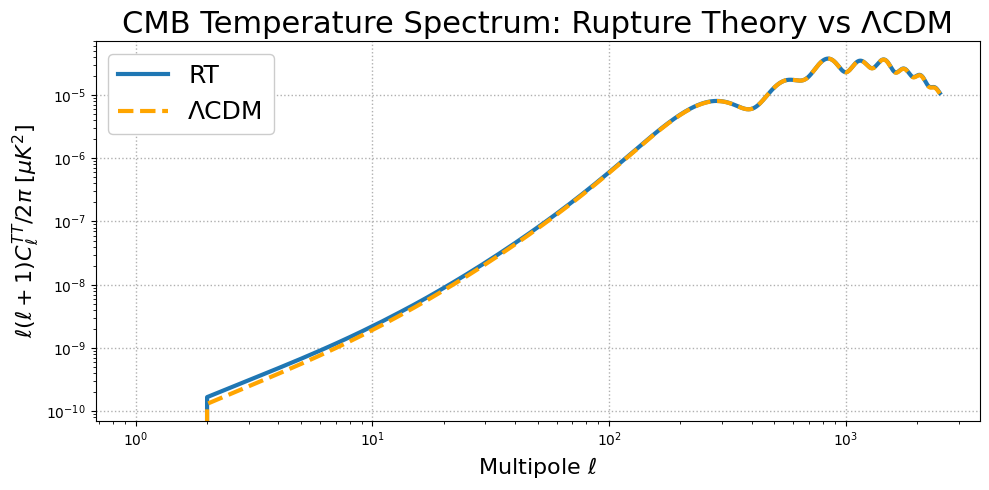

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs('images', exist_ok=True)
data_dir = 'data'

ells, tt_lcdm = np.loadtxt(f'{data_dir}/LCDM_TT.dat', comments='#', usecols=(0,1), unpack=True)
_,    tt_rt   = np.loadtxt(f'{data_dir}/Rupture_TT.dat', comments='#', usecols=(0,1), unpack=True)

factor = ells * (ells+1) / (2*np.pi)
tt_lcdm_plot = factor * tt_lcdm
tt_rt_plot   = factor * tt_rt

plt.figure(figsize=(10,5))
plt.loglog(ells, tt_rt_plot,   label='RT', linewidth=3)
plt.loglog(ells, tt_lcdm_plot, '--', label='ΛCDM', linewidth=3, color='orange')
plt.xlabel(r'Multipole $\ell$', fontsize=16)
plt.ylabel(r'$\ell(\ell + 1)C_\ell^{TT}/2\pi\ [\mu K^2]$', fontsize=16)
plt.title('CMB Temperature Spectrum: Rupture Theory vs ΛCDM', fontsize=22)
plt.legend(framealpha=1, facecolor='white', loc='upper left', fontsize=18)
plt.grid(True, linestyle=':', linewidth=1)
plt.tight_layout()
plt.savefig('images/tt_rt_vs_lcdm.png', dpi=300)
plt.show()

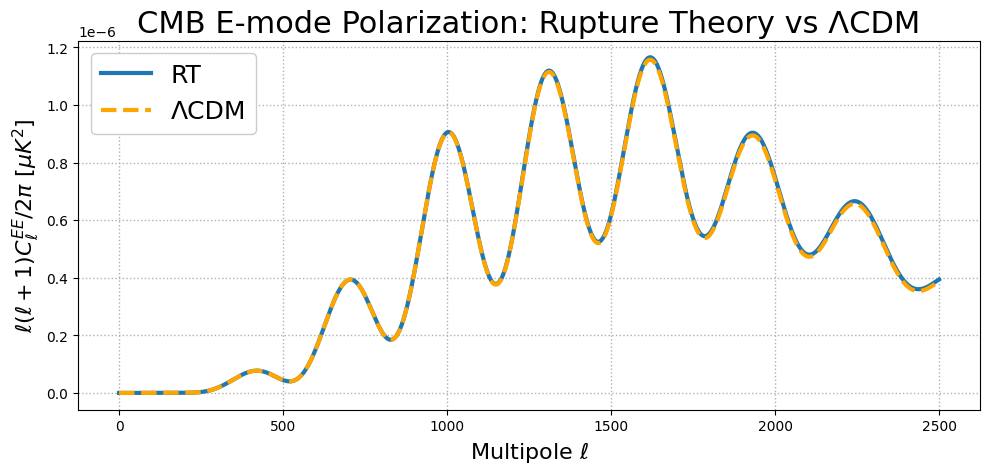

In [16]:
ells, ee_lcdm = np.loadtxt(f'{data_dir}/LCDM_EE.dat', comments='#', usecols=(0,1), unpack=True)
_,    ee_rt   = np.loadtxt(f'{data_dir}/Rupture_CAMB_EE.dat', comments='#', usecols=(0,1), unpack=True)

factor = ells * (ells+1) / (2*np.pi)
ee_lcdm_plot = factor * ee_lcdm
ee_rt_plot   = factor * ee_rt

plt.figure(figsize=(10,5))
plt.plot(ells, ee_rt_plot,   label='RT', linewidth=3)
plt.plot(ells, ee_lcdm_plot, '--', label='ΛCDM', linewidth=3, color='orange')
plt.xlabel(r'Multipole $\ell$', fontsize=16)
plt.ylabel(r'$\ell(\ell + 1)C_\ell^{EE}/2\pi\ [\mu K^2]$', fontsize=16)
plt.title('CMB E-mode Polarization: Rupture Theory vs ΛCDM', fontsize=22)
plt.legend(framealpha=1, facecolor='white', loc='upper left', fontsize=18)
plt.grid(True, linestyle=':', linewidth=1)
plt.tight_layout()
plt.savefig('images/ee_rt_vs_lcdm.png', dpi=300)
plt.show()

/tmp/ipython-input-17-2186302665.py:3: RuntimeWarning: invalid value encountered in divide
  delta_tt = (tt_rt - tt_lcdm) / tt_lcdm


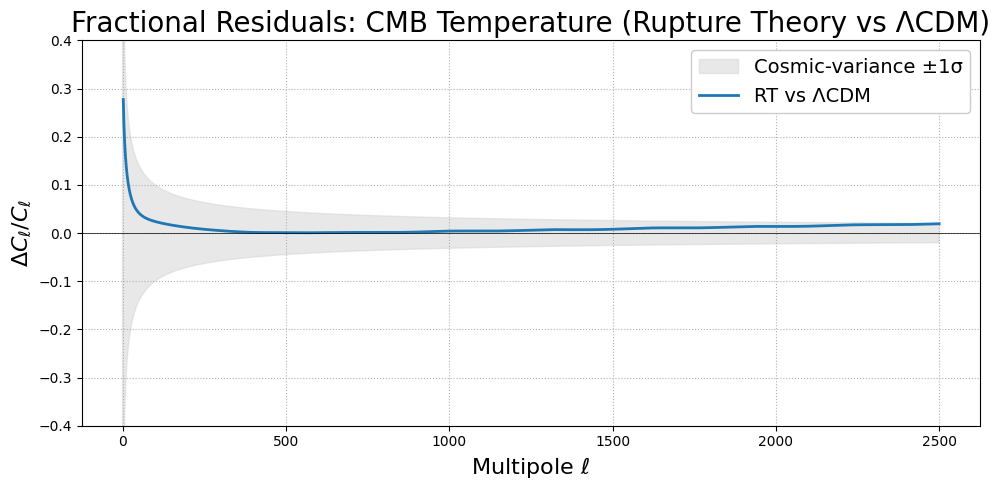

In [17]:
# TT residuals with CV
cv = np.sqrt(2/(2*ells+1))
delta_tt = (tt_rt - tt_lcdm) / tt_lcdm

plt.figure(figsize=(10,5))
plt.fill_between(ells, -cv, cv, color='lightgray', alpha=0.5, label='Cosmic-variance ±1σ')
plt.plot(ells, delta_tt, 'C0-', label='RT vs ΛCDM', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel(r'Multipole $\ell$', fontsize=16)
plt.ylabel(r'$\Delta C_\ell / C_\ell$', fontsize=16)
plt.title('Fractional Residuals: CMB Temperature (Rupture Theory vs ΛCDM)', fontsize=20)
plt.legend(framealpha=1, facecolor='white', loc='upper right', fontsize=14)
plt.grid(True, linestyle=':', linewidth=0.8)
plt.ylim(-0.4, 0.4)
plt.tight_layout()
plt.savefig('images/tt_fr.png', dpi=300)
plt.show()

/tmp/ipython-input-18-2144288055.py:2: RuntimeWarning: invalid value encountered in divide
  delta_ee = (ee_rt - ee_lcdm) / ee_lcdm


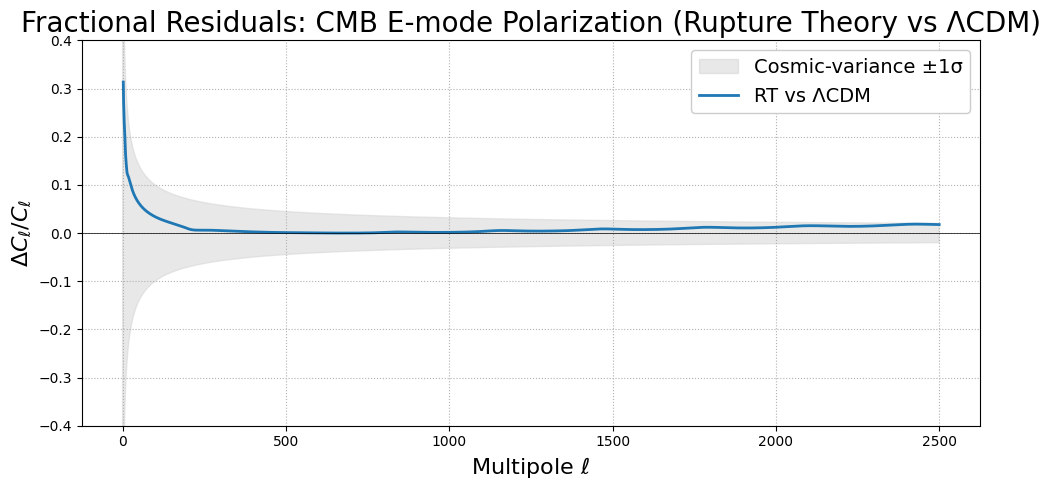

In [18]:
cv_ee = np.sqrt(2/(2*ells+1))
delta_ee = (ee_rt - ee_lcdm) / ee_lcdm

plt.figure(figsize=(10,5))
plt.fill_between(ells, -cv_ee, cv_ee, color='lightgray', alpha=0.5, label='Cosmic-variance ±1σ')
plt.plot(ells, delta_ee, 'C0-', label='RT vs ΛCDM', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel(r'Multipole $\ell$', fontsize=16)
plt.ylabel(r'$\Delta C_\ell / C_\ell$', fontsize=16)
plt.title('Fractional Residuals: CMB E-mode Polarization (Rupture Theory vs ΛCDM)', fontsize=20)
plt.legend(framealpha=1, facecolor='white', loc='upper right', fontsize=14)
plt.grid(True, linestyle=':', linewidth=0.8)
plt.ylim(-0.4, 0.4)
plt.tight_layout()
plt.savefig('images/ee_fr.png', dpi=300)
plt.show()

/tmp/ipython-input-19-1962042946.py:4: RuntimeWarning: invalid value encountered in divide
  frac = (clpp_rt - clpp_lcdm) / clpp_lcdm


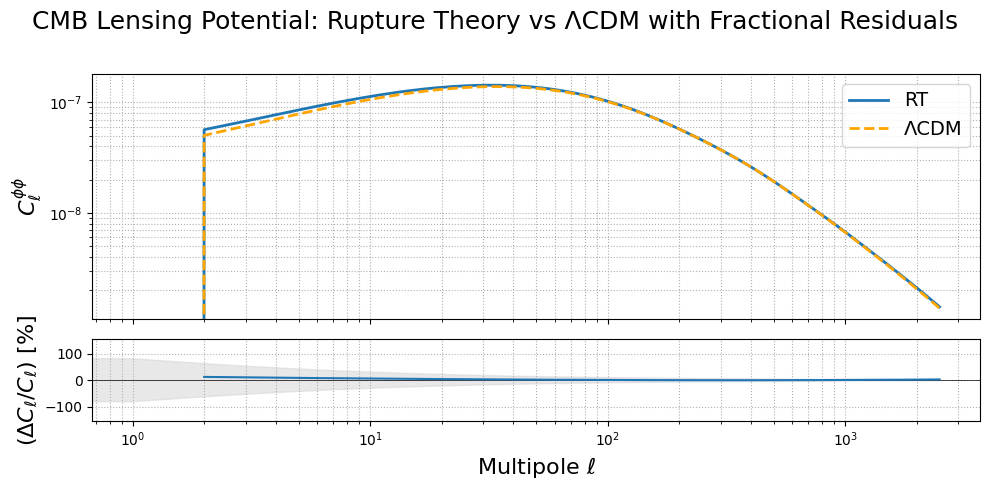

In [19]:
ells, clpp_lcdm = np.loadtxt(f'{data_dir}/LCDM_Clpp.dat', comments='#', usecols=(0,1), unpack=True)
_,    clpp_rt   = np.loadtxt(f'{data_dir}/Rupture_Clpp.dat', comments='#', usecols=(0,1), unpack=True)

frac = (clpp_rt - clpp_lcdm) / clpp_lcdm
cv   = np.sqrt(2/(2*ells+1))

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,5), gridspec_kw={'height_ratios':[3,1]})
fig.suptitle('CMB Lensing Potential: Rupture Theory vs ΛCDM with Fractional Residuals', fontsize=18, y=0.97)

ax1.loglog(ells, clpp_rt,   label='RT', linewidth=2)
ax1.loglog(ells, clpp_lcdm, '--', label='ΛCDM', linewidth=2, color='orange')
ax1.set_ylabel(r'$C_\ell^{\phi\phi}$', fontsize=16)
ax1.legend(loc='upper right', fontsize=14)
ax1.grid(True, which='both', linestyle=':', linewidth=0.8)

ax2.axhline(0, color='k', linewidth=0.5)
ax2.plot(ells, 100*frac, 'C0-')
ax2.fill_between(ells, -100*cv, 100*cv, color='lightgray', alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'Multipole $\ell$', fontsize=16)
ax2.set_ylabel(r'$(\Delta C_\ell/C_\ell)\ [\%]$', fontsize=16)
ax2.grid(True, which='both', linestyle=':', linewidth=0.8)

plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('images/lensing_residual.png', dpi=300)
plt.show()

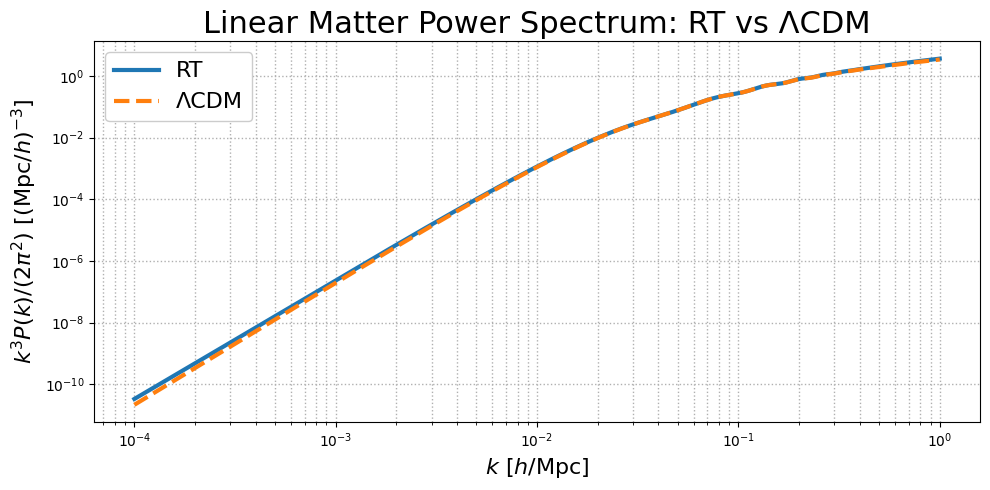

In [20]:
k_lcdm, pk_lcdm = np.loadtxt(f'{data_dir}/LCDM_Pk.dat', comments='#', usecols=(0,1), unpack=True)
k_rt,   pk_rt   = np.loadtxt(f'{data_dir}/Rupture_Pk.dat', comments='#', usecols=(0,1), unpack=True)

dim_lcdm = k_lcdm**3 * pk_lcdm / (2 * np.pi**2)
dim_rt   = k_rt  **3 * pk_rt   / (2 * np.pi**2)

plt.figure(figsize=(10,5))
plt.loglog(k_rt,   dim_rt,   'C0-',  label='RT', linewidth=3)
plt.loglog(k_lcdm, dim_lcdm, 'C1--', label='ΛCDM', linewidth=3)
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=16)
plt.ylabel(r'$k^3P(k)/(2\pi^2)\ [(\mathrm{Mpc}/h)^{-3}]$', fontsize=16)
plt.title('Linear Matter Power Spectrum: RT vs ΛCDM', fontsize=22)
plt.grid(True, which='both', linestyle=':', linewidth=1)
plt.legend(framealpha=1, facecolor='white', loc='upper left', fontsize=16)
plt.tight_layout()
plt.savefig('images/matter_power.png', dpi=300)
plt.show()